# Lap Time Prediction Model

In [136]:
!pip install fastf1

In [137]:
import fastf1
from fastf1 import plotting
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np


In [138]:
import os
os.makedirs('./f1_cache', exist_ok=True)

### Load Dataset

In [139]:
fastf1.Cache.enable_cache('./f1_cache')  

# Load Silverstone FP1 in 2025
session = fastf1.get_session(2025, "Silverstone", "FP1")
session.load()

core           INFO 	Loading data for British Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '23', '30', '31', '36', '43', '44', '55', '63', '81', '87', '97']


### Check Features

In [140]:
laps = session.laps
weather = session.weather_data

laps = laps.sort_values("LapStartTime")
weather = weather.sort_values("Time")

merged = pd.merge_asof(
    laps,
    weather,
    left_on="LapStartTime",
    right_on="Time",
    direction="backward"
)

# Drop rows with NaT in LapTime
merged = merged.dropna(subset=['LapTime'])

# Remove columns that directly encode lap time or its components (to avoid target leakage)
patterns = ['Sector', 'Speed', 'Pit', 'SessionTime', 'StartTime', 'Time_x', 'Time_y', 'LapStartTime']
drop_cols = [col for col in merged.columns if any(p in col for p in patterns)]
merged = merged.drop(columns=drop_cols)

merged.head()

,Driver,DriverNumber,LapTime,LapNumber,Stint,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,...,Deleted,DeletedReason,FastF1Generated,IsAccurate,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection
15,SAI,55,0 days 00:02:21.478000,2.0,2.0,False,HARD,2.0,False,Williams,...,False,,False,False,22.0,43.0,1008.3,False,38.3,235
17,ALB,23,0 days 00:02:25.781000,2.0,2.0,False,HARD,2.0,False,Williams,...,False,,False,False,22.0,43.0,1008.4,False,38.4,199
18,OCO,31,0 days 00:01:46.005000,2.0,1.0,False,MEDIUM,2.0,True,Haas F1 Team,...,False,,False,False,22.0,43.0,1008.4,False,38.4,199
21,BOR,5,0 days 00:01:32.785000,2.0,1.0,True,MEDIUM,2.0,True,Kick Sauber,...,False,,False,True,22.0,43.0,1008.4,False,38.4,199
22,ARO,97,0 days 00:01:33.923000,2.0,1.0,True,MEDIUM,2.0,True,Kick Sauber,...,False,,False,True,22.0,43.0,1008.4,False,38.4,199


In [141]:
data = merged.copy()

# Create lap time (in seconds) and previous-lap time feature
data['LapTimeSec'] = data['LapTime'].dt.total_seconds()
data['PrevLapTimeSec'] = data.groupby('Driver')['LapTimeSec'].shift(1) # Group by Driver
data = data.drop(columns='LapTime')

# Drop rows where previous lap time is not available
data = data.dropna(subset=['PrevLapTimeSec'])

### Split Train/Test

Time-series data  
shuffle = False

In [142]:
train, test = train_test_split(
    data,
    test_size=0.2,
    shuffle=False
)

In [143]:
numeric_cols = train.select_dtypes(include='number').columns

corr = train[numeric_cols].corr()
corr

,LapNumber,Stint,TyreLife,Position,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,LapTimeSec,PrevLapTimeSec
LapNumber,1.000000,0.835143,0.541934,NaN,0.935128,-0.836467,-0.893479,0.889081,0.298396,-0.154201,-0.072650
Stint,0.835143,1.000000,0.398523,NaN,0.855075,-0.772735,-0.779778,0.782056,0.306327,-0.176425,-0.045185
TyreLife,0.541934,0.398523,1.000000,NaN,0.458085,-0.401253,-0.443838,0.336664,0.081005,-0.249167,-0.185232
Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AirTemp,0.935128,0.855075,0.458085,NaN,1.000000,-0.888149,-0.889073,0.905916,0.330318,-0.167815,-0.065568
Humidity,-0.836467,-0.772735,-0.401253,NaN,-0.888149,1.000000,0.789074,-0.797504,-0.393413,0.176204,0.080043
Pressure,-0.893479,-0.779778,-0.443838,NaN,-0.889073,0.789074,1.000000,-0.898121,-0.244010,0.157375,0.028629
TrackTemp,0.889081,0.782056,0.336664,NaN,0.905916,-0.797504,-0.898121,1.000000,0.264500,-0.123885,0.035658
WindDirection,0.298396,0.306327,0.081005,NaN,0.330318,-0.393413,-0.244010,0.264500,1.000000,0.038477,-0.095227
LapTimeSec,-0.154201,-0.176425,-0.249167,NaN,-0.167815,0.176204,0.157375,-0.123885,0.038477,1.000000,-0.330626


In [144]:
# Select the top 8 features most correlated with LapTimeSec
target_corr = corr['LapTimeSec'].drop('LapTimeSec')

top8 = target_corr.abs().sort_values(ascending=False).head(8)
top8_with_sign = target_corr.loc[top8.index]

top8_with_sign

PrevLapTimeSec   -0.330626
TyreLife         -0.249167
Stint            -0.176425
Humidity          0.176204
AirTemp          -0.167815
Pressure          0.157375
LapNumber        -0.154201
TrackTemp        -0.123885
Name: LapTimeSec, dtype: float64

In [145]:
# Final feature set: top 8 numeric features + 2 categorical features
selected_features = list(top8.index)
selected_features += ['Compound', 'TrackStatus']

In [146]:
# Prepare train/test set

# One-hot encoding
train_encoded = pd.get_dummies(train[selected_features], drop_first=True)
test_encoded = pd.get_dummies(test[selected_features], drop_first=True)

# Align columns (align missing dummy columns in the test set)
train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1)
test_encoded = test_encoded.fillna(0)  # missing dummy columns in the test set: filled with 0

# Final X, y
X_train = train_encoded
y_train = train['LapTimeSec']

X_test = test_encoded
y_test = test['LapTimeSec']

### Model Training

#### Baseline - Global Model
Train Model with whole dataset

In [147]:
model_baseline = RandomForestRegressor(
        n_estimators=200,
        random_state=42
    )
model_baseline.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [148]:
# Overall MAE
pred_global = model_baseline.predict(X_test)
mae = mean_absolute_error(y_test, pred_global)

print("MAE:", mae)

# MAE for each driver
drivers = test['Driver'].unique()
mae_per_driver = {}

for drv in drivers:
    idx = (test['Driver'] == drv)
    y_true = y_test[idx]
    y_pred = pred_global [idx]
    
    mae_per_driver[drv] = mean_absolute_error(y_true, y_pred)

# Display MAE sorted by performance
for drv, mae in sorted(mae_per_driver.items(), key=lambda x: x[1]):
    print(f"{drv}: MAE = {mae:.3f}")


MAE: 18.292189932432436
LAW: MAE = 0.501
COL: MAE = 8.396
ARO: MAE = 10.444
LEC: MAE = 11.591
HAM: MAE = 11.796
GAS: MAE = 12.414
HAD: MAE = 14.664
BOR: MAE = 15.590
NOR: MAE = 19.271
ALO: MAE = 20.213
BEA: MAE = 20.805
SAI: MAE = 21.103
ANT: MAE = 21.897
RUS: MAE = 22.810
VER: MAE = 23.159
OCO: MAE = 23.370
STR: MAE = 23.789
PIA: MAE = 23.897
ALB: MAE = 24.296
LIN: MAE = 34.274


#### Model For Each Driver
Train Model for each driver.  
Train a model for each driver to capture individual driving-style differences and enable driver-specific predictions.

In [149]:
drivers = train['Driver'].unique()

models = {}
pred_all = np.zeros(len(test))

for drv in drivers:
    # 1) Train/test indices for each driver
    train_idx = (train['Driver'] == drv)
    test_idx = (test['Driver'] == drv)

    # Skip drivers that do not appear in the test set
    if test_idx.sum() == 0:
        continue

    X_train_drv = X_train[train_idx]
    y_train_drv = y_train[train_idx]

    X_test_drv = X_test[test_idx]

    # 2) Train a driver-specific model
    model = RandomForestRegressor(
        n_estimators=200,
        random_state=42
    )
    model.fit(X_train_drv, y_train_drv)

    models[drv] = model

    # 3) Store predictions for this driver in the global test array
    pred_all[test_idx] = model.predict(X_test_drv)



In [150]:
# MAE for each driver
mae_per_driver = {}

for drv in drivers:
    test_idx = (test['Driver'] == drv)
    
    # Skip drivers that do not appear in the test set
    if test_idx.sum() == 0:
        continue
    
    y_true_drv = y_test[test_idx]
    y_pred_drv = pred_all[test_idx]
    
    mae_per_driver[drv] = mean_absolute_error(y_true_drv, y_pred_drv)

for drv, mae in sorted(mae_per_driver.items(), key=lambda x: x[1]):
    print(f"{drv}: MAE = {mae:.3f}")

ARO: MAE = 1.348
LAW: MAE = 1.486
COL: MAE = 8.815
LEC: MAE = 11.758
LIN: MAE = 13.169
SAI: MAE = 13.983
HAM: MAE = 14.648
BOR: MAE = 15.039
HAD: MAE = 15.522
NOR: MAE = 19.554
BEA: MAE = 20.013
ALO: MAE = 20.213
GAS: MAE = 20.305
ALB: MAE = 20.747
ANT: MAE = 22.909
VER: MAE = 23.115
RUS: MAE = 23.370
OCO: MAE = 23.544
PIA: MAE = 24.079
STR: MAE = 26.198


In [151]:
# MAE on the full test set (using driver-specific models)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred_all)

print("MAE:", mae)

MAE: 18.04327567567567


### Visulaization

Visualization comparing the actual lap times and driver-specific model predictions to evaluate performance differences across drivers.

In [152]:
team_colors = {
    'Red Bull Racing': '#3671C6',
    'Ferrari': '#DC0000',
    'Mercedes': '#00D2BE',
    'McLaren': '#FF8700',
    'Aston Martin': '#006F62',
    'Alpine': '#0090FF',
    'Williams': '#005AFF',
    'RB': '#1E41FF',                 
    'Kick Sauber': '#00E701', 
    'Haas': '#B6BABD',
}

# Get Team name for each drivers
driver_to_team = data[['Driver', 'Team']].drop_duplicates().set_index('Driver')['Team'].to_dict()

# Add team information and predictions to the test set
test_plot = test.copy()
test_plot['PredGlobal'] = pred_global 
test_plot['PredDriver'] = pred
test_plot['Team'] = test_plot['Driver'].map(driver_to_team)

# Map team colours
test_plot['Color'] = test_plot['Team'].map(team_colors).fillna('#555555')


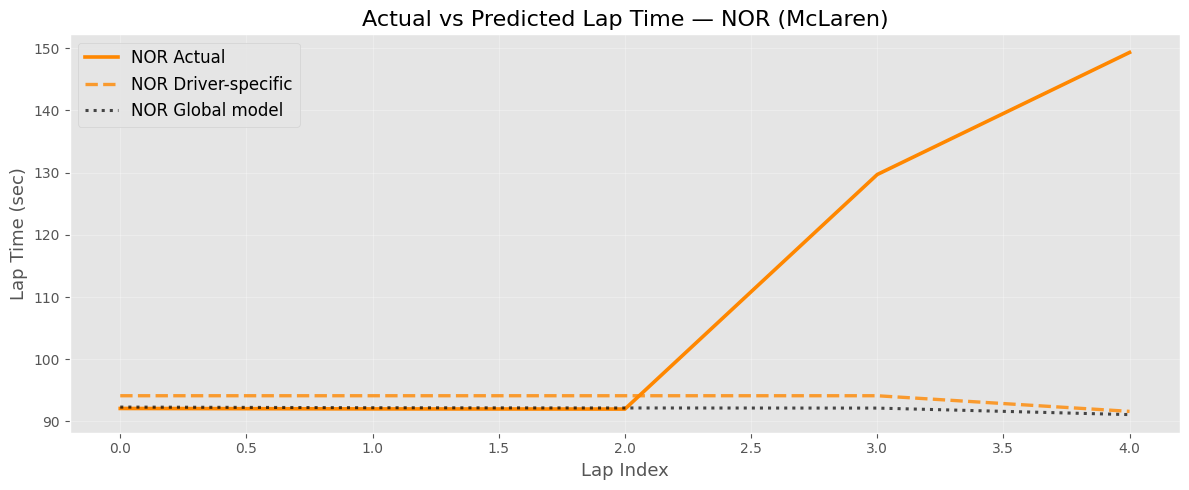

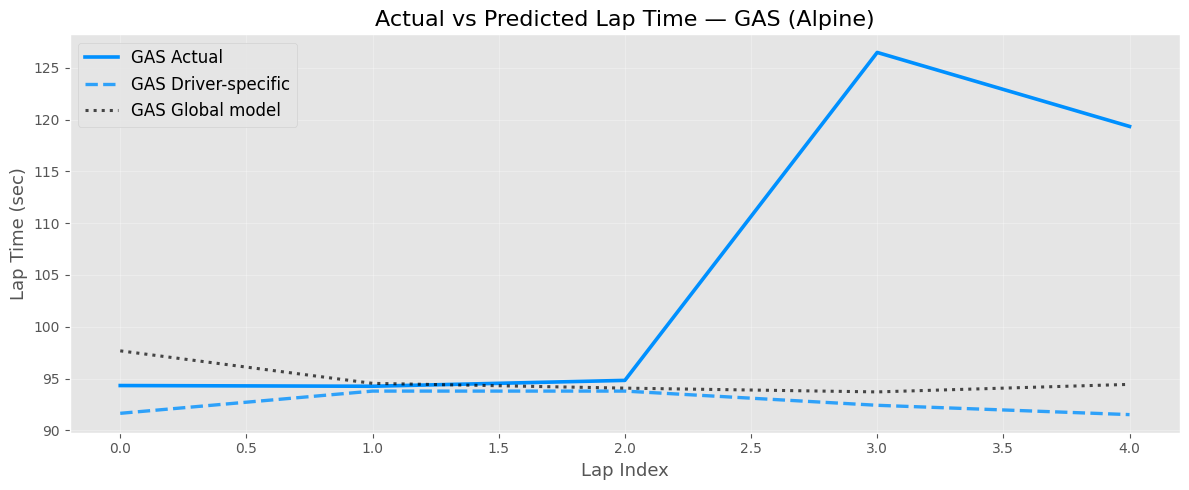

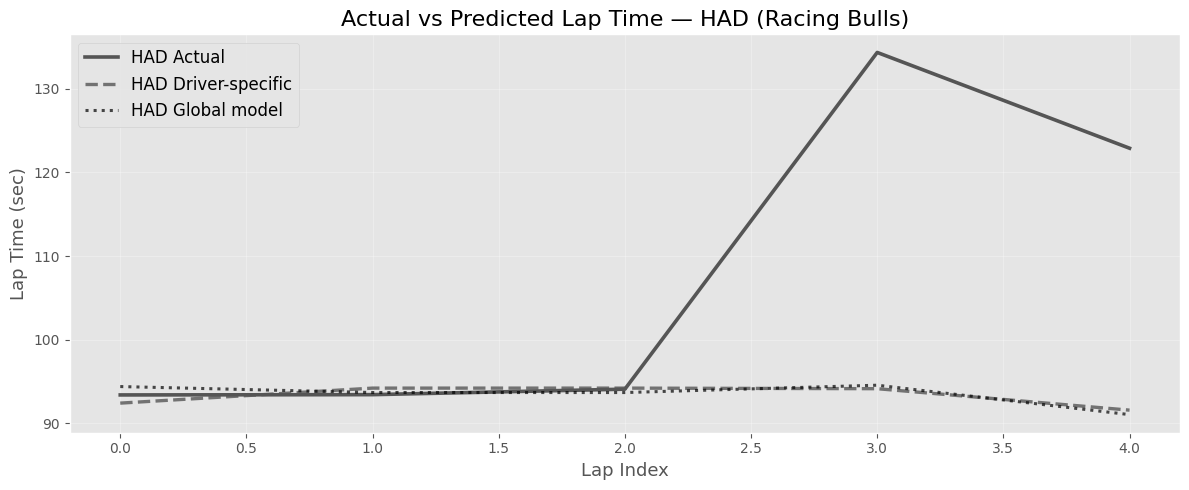

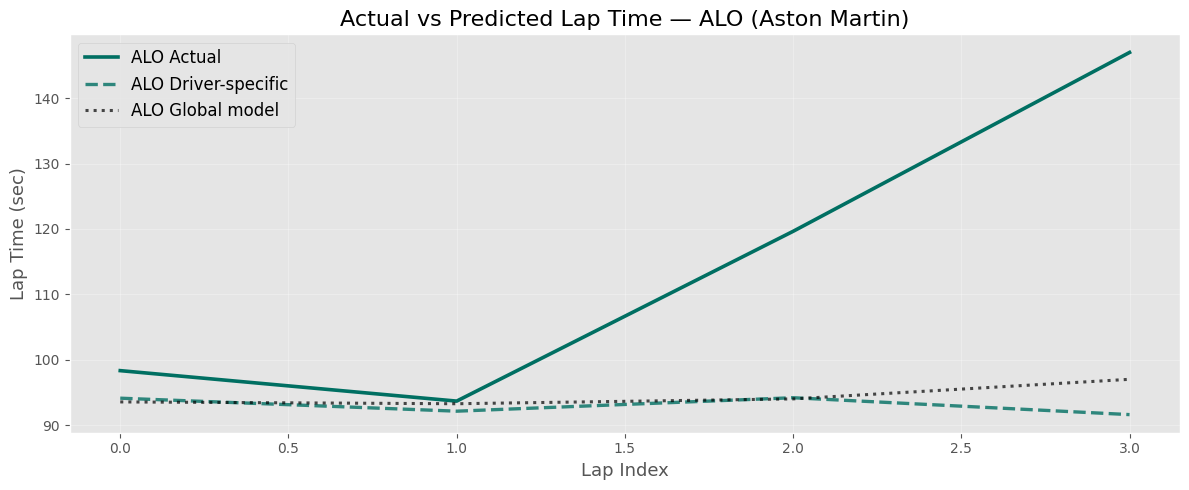

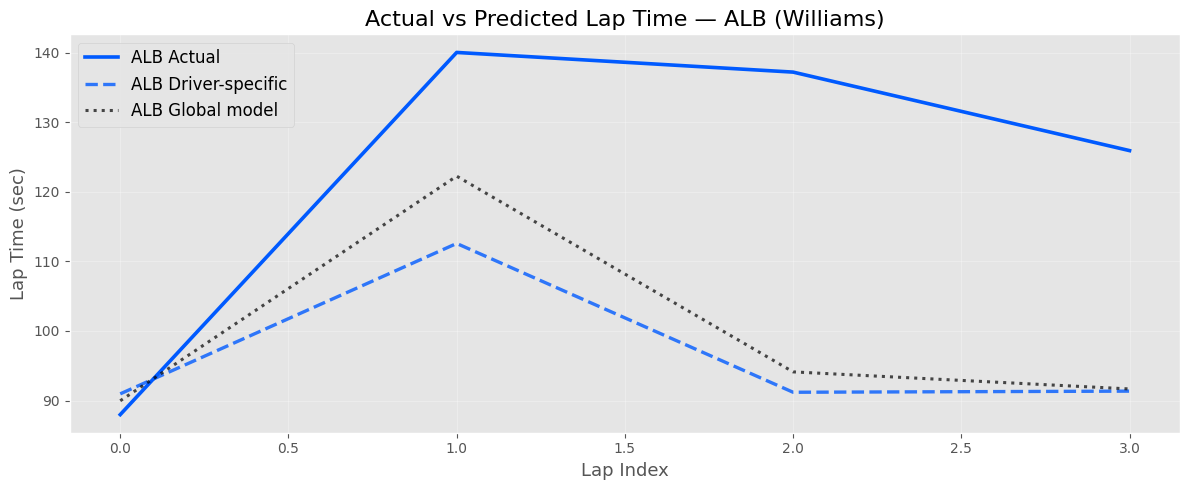

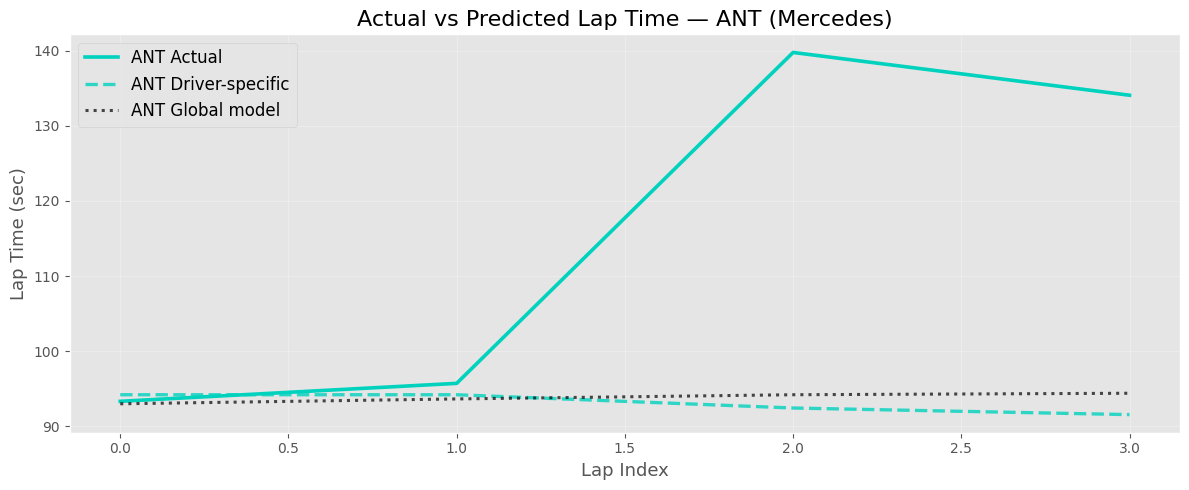

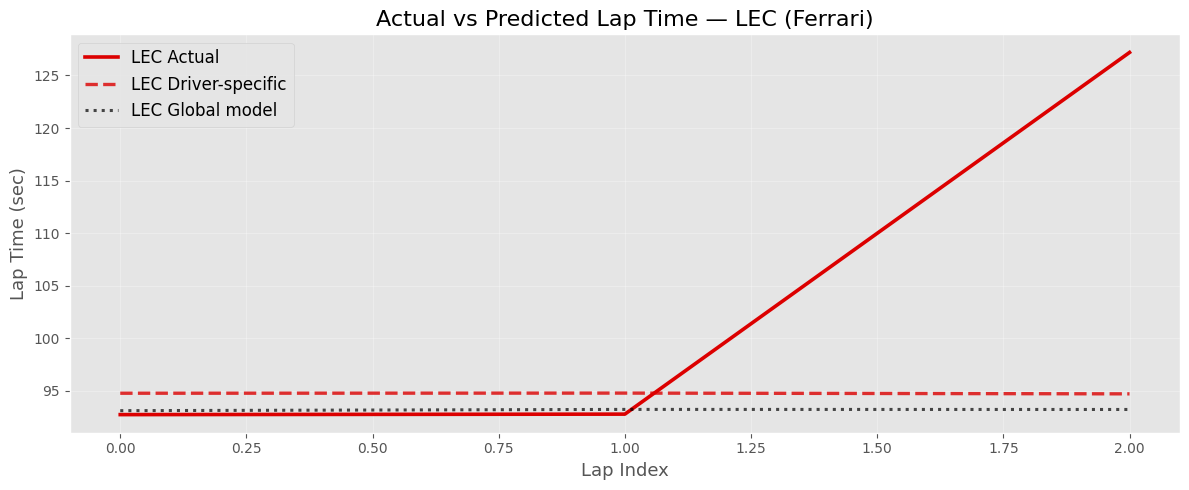

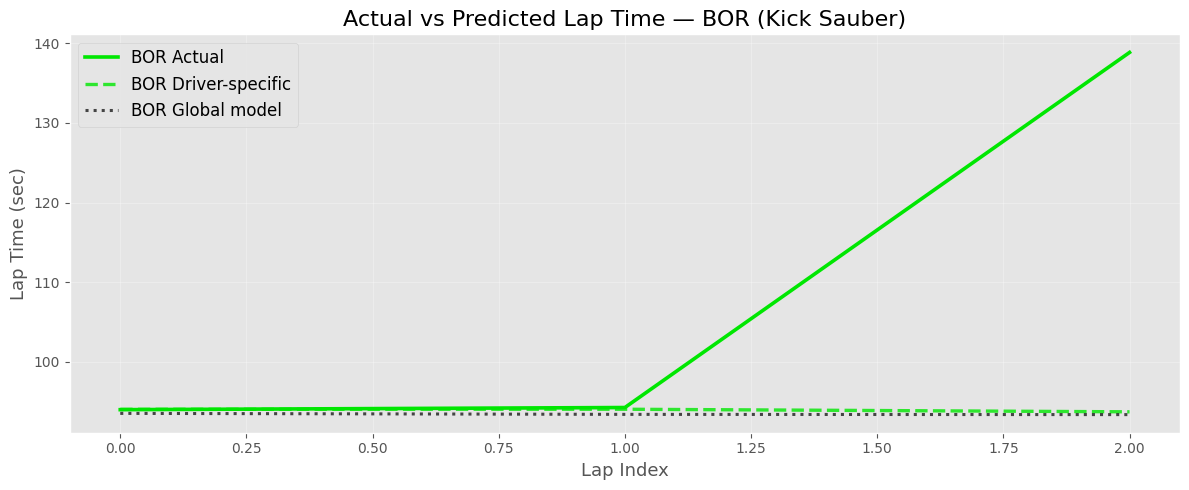

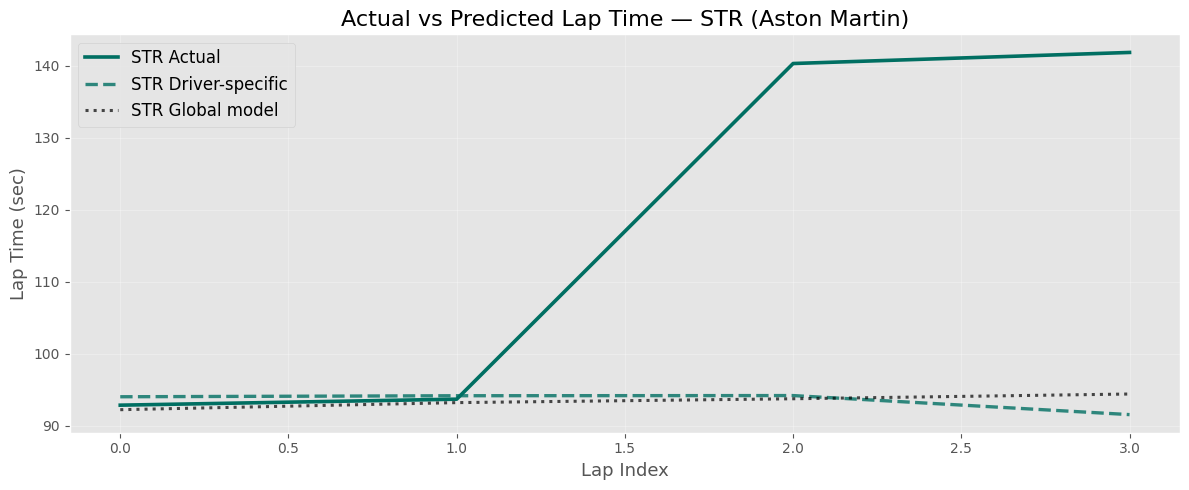

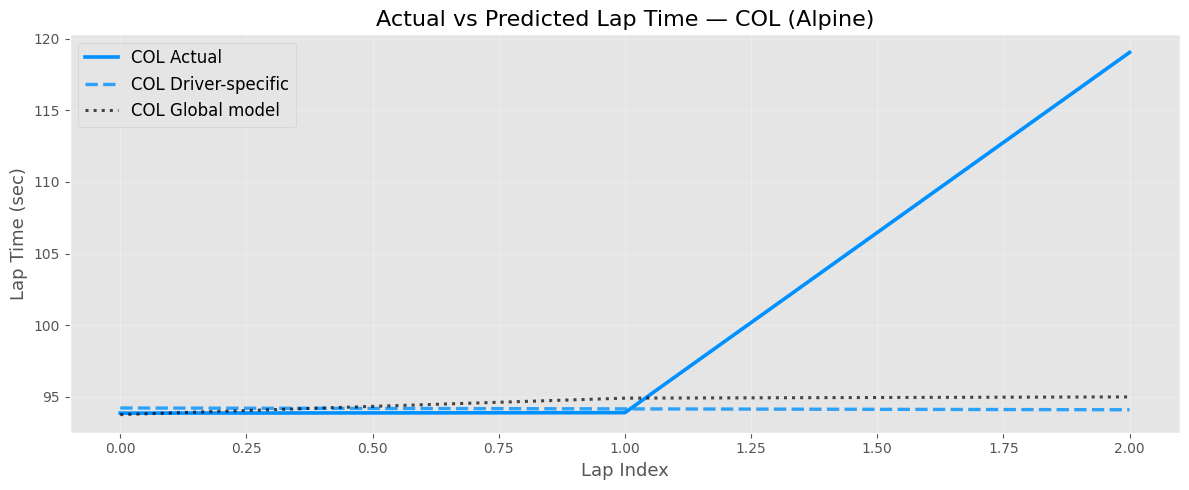

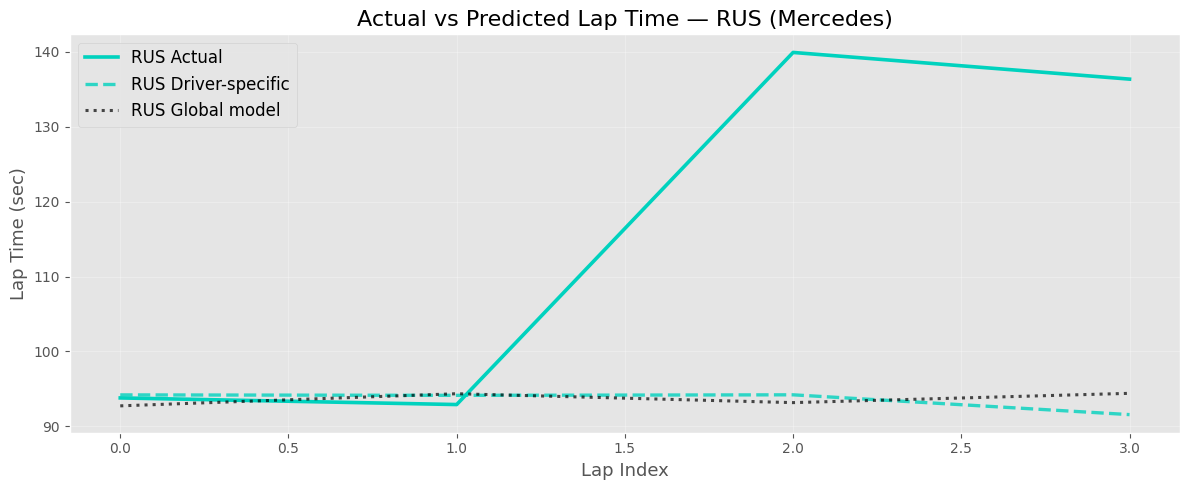

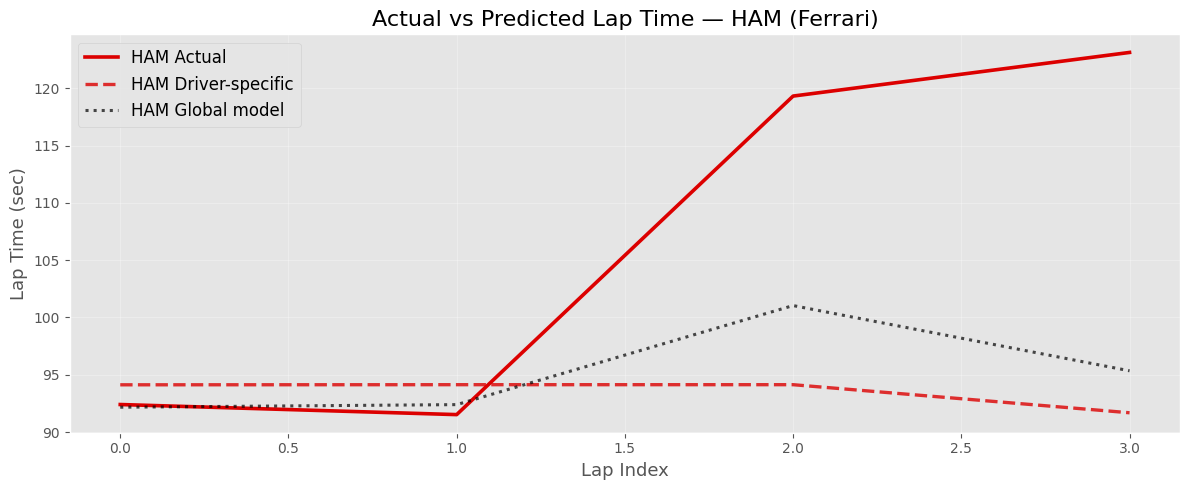

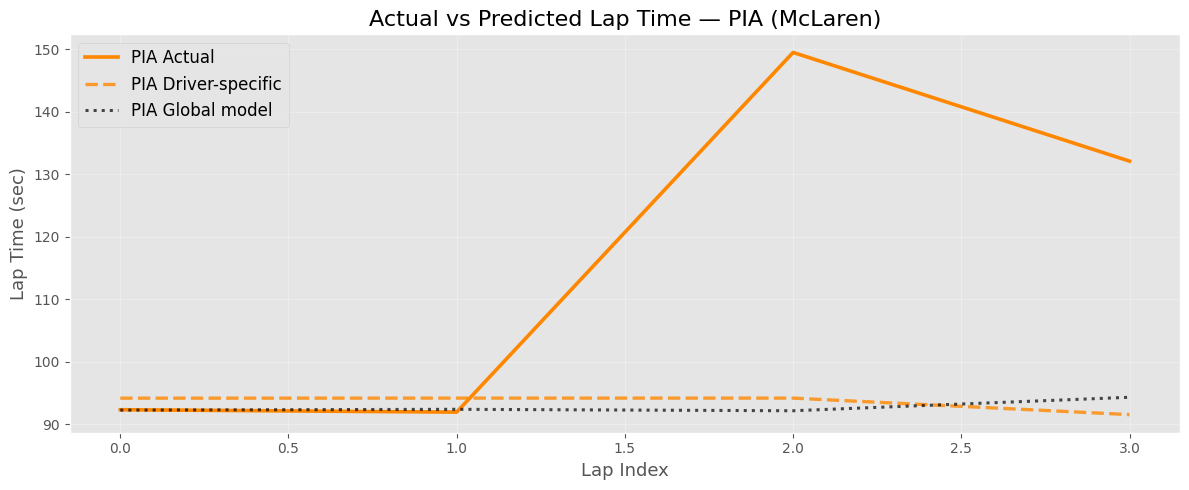

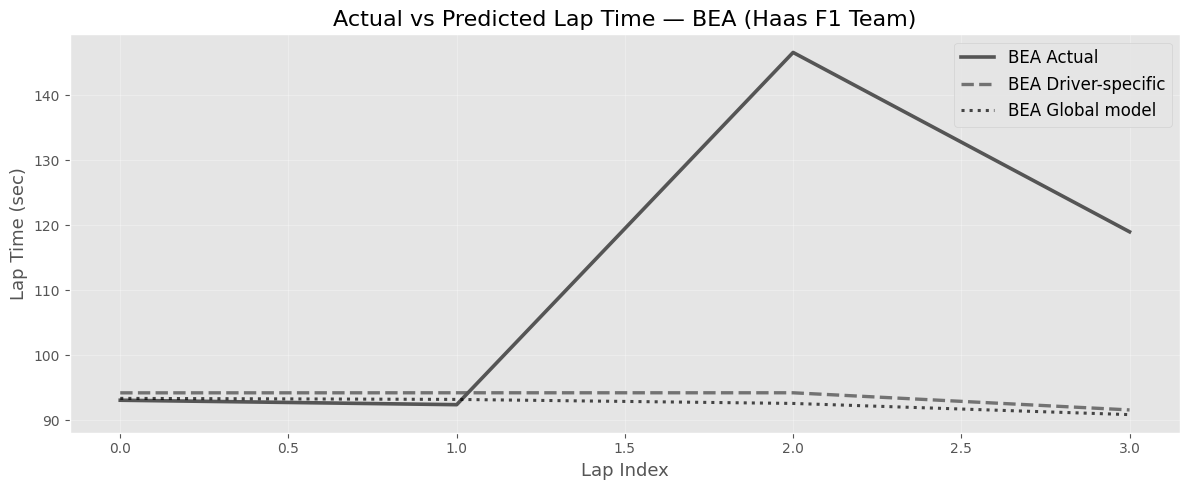

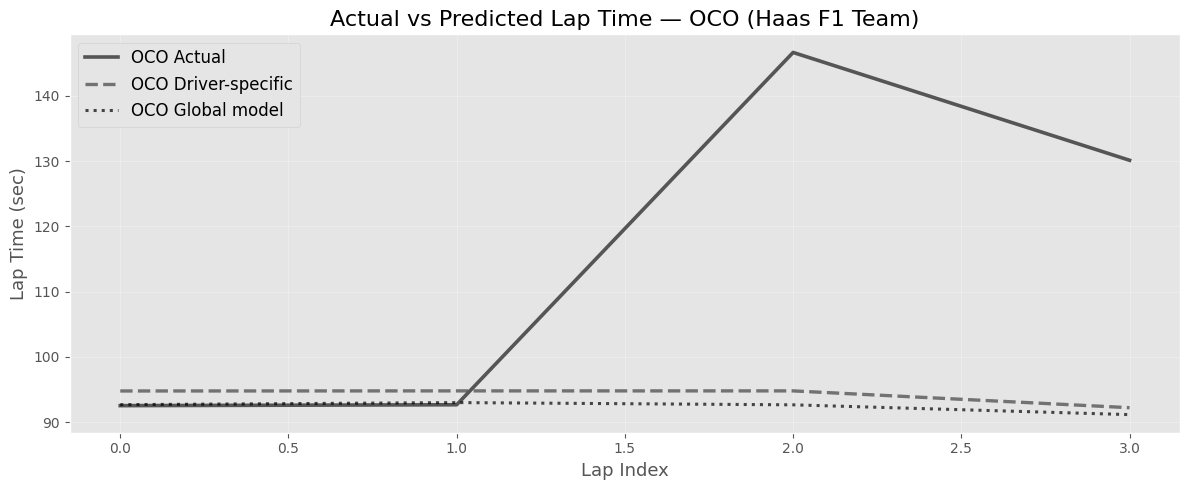

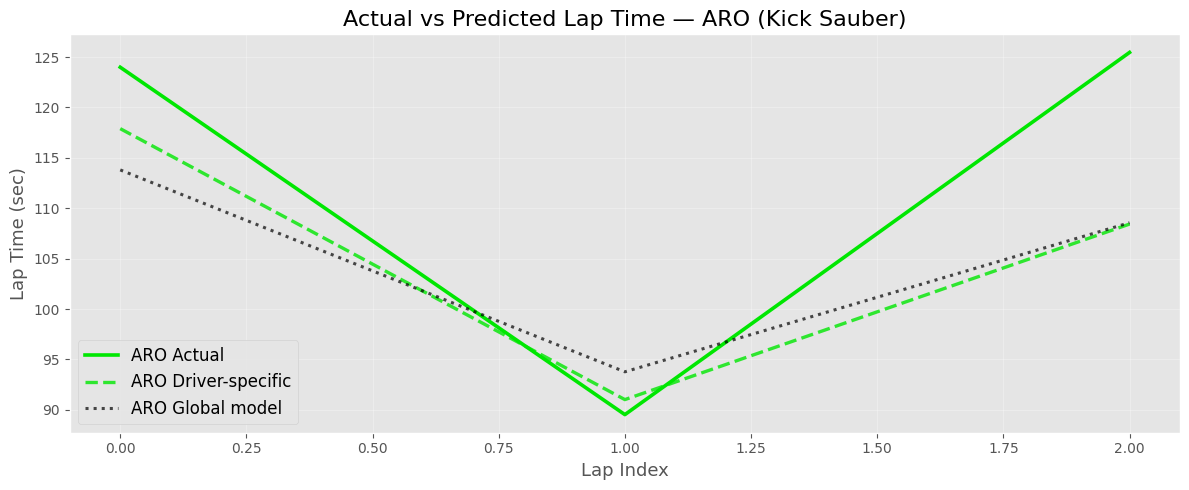

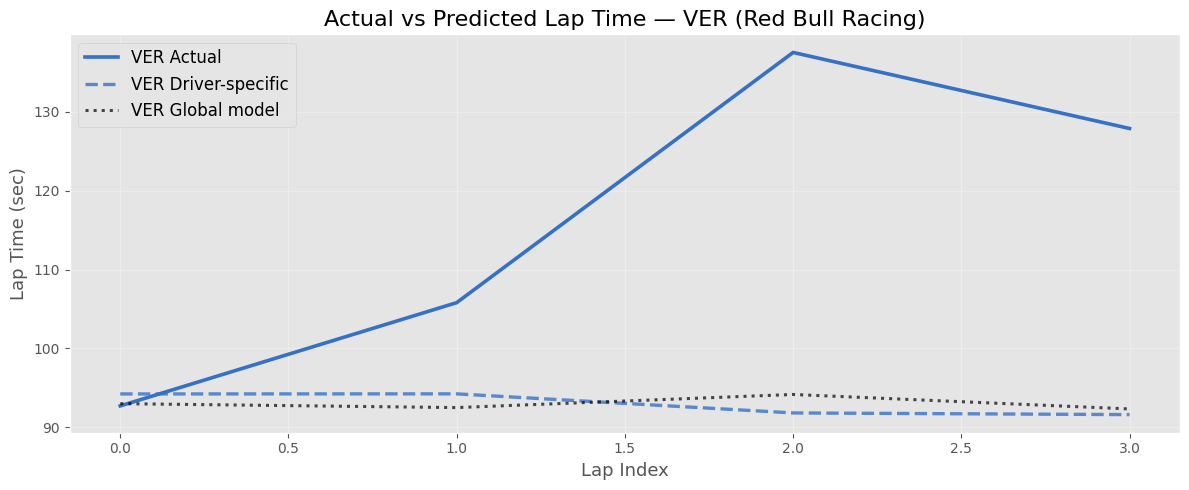

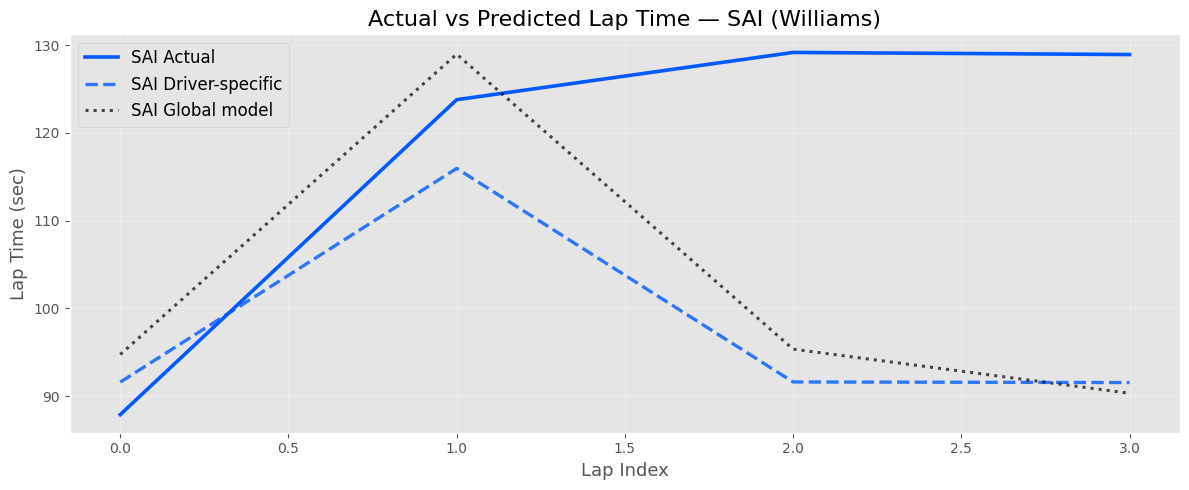

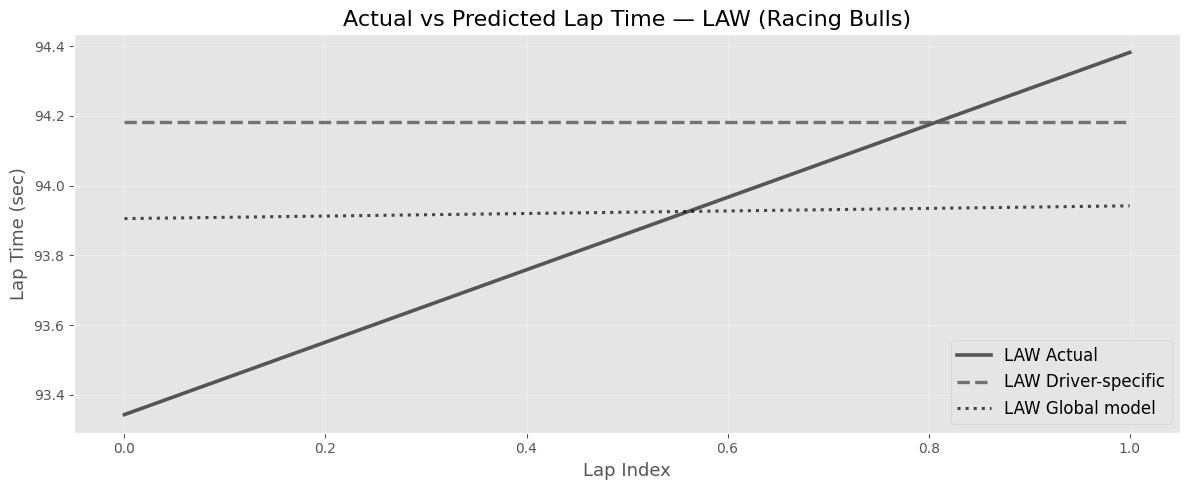

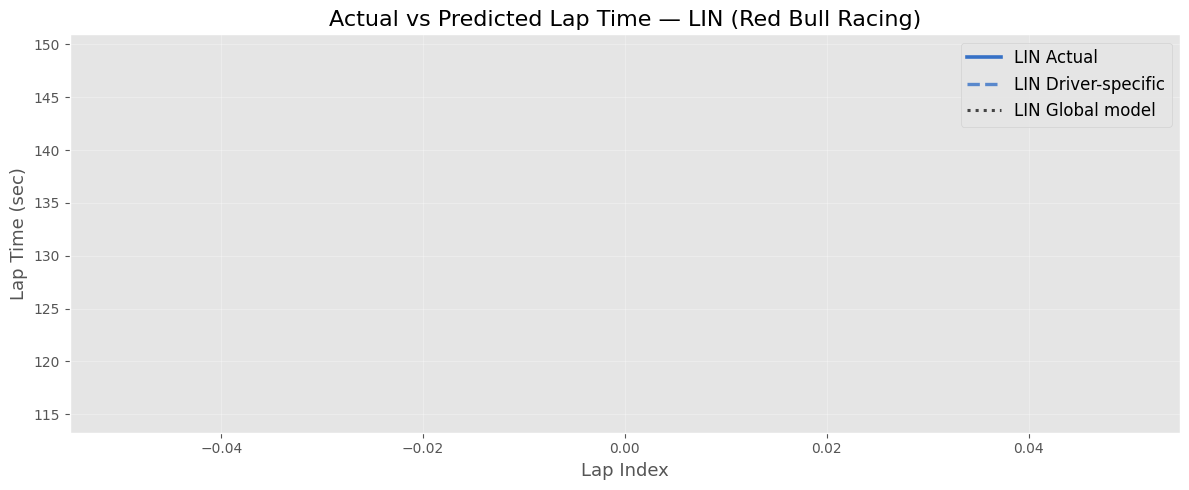

In [153]:
plt.style.use('ggplot')

drivers = test_plot['Driver'].unique()

for drv in drivers:
    drv_data = test_plot[test_plot['Driver'] == drv]

    color = drv_data['Color'].iloc[0]
    team_name = drv_data['Team'].iloc[0]

    plt.figure(figsize=(12, 5))

    # Actual lap times
    plt.plot(
        drv_data['LapTimeSec'].values,
        label=f'{drv} Actual',
        linewidth=2.6,
        color=color
    )

    # Driver-specific model prediction (same team colour, dashed)
    plt.plot(
        drv_data['PredDriver'].values,
        label=f'{drv} Driver-specific',
        linewidth=2.4,
        color=color,
        linestyle='--',
        alpha=0.8
    )

    # Global model prediction (neutral colour, dotted)
    plt.plot(
        drv_data['PredGlobal'].values,
        label=f'{drv} Global model',
        linewidth=2.2,
        color='black',
        linestyle=':',
        alpha=0.7
    )

    plt.title(f'Actual vs Predicted Lap Time — {drv} ({team_name})', fontsize=16)
    plt.xlabel('Lap Index', fontsize=13)
    plt.ylabel('Lap Time (sec)', fontsize=13)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
